# Graph analysis

Your task in this exercise is straightforward: produce a graph of the named entities in the literary corpus and calculate a handful of centrality measures on it. This follows notebook 09 very closely.

Your notebook should:

1. Perform entity recognition on the full corpus using Spacy.
2. Produce a `networkx` graph object of the extracted entites, where nodes are entities and edges represent weighted coöccurrence in the same text. (For a challenge, use the chunked version of the corpus to get better in-document coöccurrence resolution.) **NB.** You can use all the Spacy entity types if you want, but this produces a very large graph, which in turn makes some of the centrality measures very computationaly expensive. I'd suggest limiting the retained entity types to just a few (ideally, broadly related, like 'GPE', 'LOC', and 'FACILITY', for example).
3. Produce a list of the top 20 entities in your graph according to each of at least three different centrality measures.
4. Produce a visualization of your graph. In a perfect world, make this visualization as pretty as possible ;).

In [50]:
import spacy
import heapq
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import time

from operator import itemgetter

# Import our libraries
sys.path.append(os.path.join('..', 'libraries'))
from TMN import TMNCorpusReader, PickledCorpusReader

nlp = spacy.load('en')

#GOOD_ENTS = ['PERSON', 'NORP', 'FACILITY', 'ORG', 'GPE', 'LOC',
#             'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE']
GOOD_ENTS = ['GPE', 'LOC', 'NORP', 'FACILITY']

def entities(sent):
    doc = nlp(sent)
    for ent in doc.ents:
        #  filter out non-target entities
        if ent.label_ in GOOD_ENTS:
            #return ent.text, ent.label_
            yield ent.text, ent.label_ # <- Note this change
        else:
            pass

def pairs(doc):
    doc_entities = []
    for para in doc:
        for sent in para:
            for ent, tag in entities(' '.join(word for word, tag in sent)):
                doc_entities.append(ent)

    permuts = list(itertools.permutations(set(doc_entities), 2))
    return permuts

def graph(docs):
    G = nx.Graph(name="locations")
    completed = 0
    for doc in docs:
        if completed % 500 == 0:
            print(f'\n{time.ctime()} :: {completed} chunks complete')
            print(nx.info(G))
        for pair in pairs(doc):
            if (pair[0], pair[1]) in G.edges():
                G.edges[(pair[0], pair[1])]['weight'] += 1
            else:
                G.add_edge(pair[0], pair[1], weight=1)
        completed+=1
    return G

def nbest_centrality(G, metric, n=10, attr="centrality", **kwargs):
    # Compute the centrality scores for each vertex
    scores = metric(G, **kwargs)

    # Set the score as a property on each node
    nx.set_node_attributes(G, name=attr, values=scores)

    # Find the top n scores and print them along with their index
    topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
    for idx, item in enumerate(topn):
        print("{}. {}: {:0.4f}".format(idx + 1, *item))

    return G

In [51]:
%%time
# Where are the corpus texts on your system
pickle_dir = os.path.join('..', 'data', 'pickled_chunked')
# Set up corpus
corpus = PickledCorpusReader(pickle_dir)

# Create entity pair graph
docs = corpus.docs()
print(f'{len(corpus.fileids())} chunks to process')
G = graph(docs)

6025 chunks to process
Mon Apr 15 22:54:58 2019 :: 0 chunks complete
Name: locations
Type: Graph
Number of nodes: 0
Number of edges: 0

Mon Apr 15 22:59:14 2019 :: 500 chunks complete
Name: locations
Type: Graph
Number of nodes: 444
Number of edges: 2650
Average degree:  11.9369
Mon Apr 15 23:04:07 2019 :: 1000 chunks complete
Name: locations
Type: Graph
Number of nodes: 714
Number of edges: 4275
Average degree:  11.9748
Mon Apr 15 23:08:00 2019 :: 1500 chunks complete
Name: locations
Type: Graph
Number of nodes: 919
Number of edges: 5690
Average degree:  12.3830
Mon Apr 15 23:11:53 2019 :: 2000 chunks complete
Name: locations
Type: Graph
Number of nodes: 1523
Number of edges: 12402
Average degree:  16.2863
Mon Apr 15 23:15:40 2019 :: 2500 chunks complete
Name: locations
Type: Graph
Number of nodes: 1721
Number of edges: 14550
Average degree:  16.9088
Mon Apr 15 23:19:55 2019 :: 3000 chunks complete
Name: locations
Type: Graph
Number of nodes: 1855
Number of edges: 15400
Average degree

In [52]:
# Write the graph to disk
graph_dir = os.path.join('..', 'data', 'graphs')
nx.write_graphml(G, os.path.join(graph_dir, "ps09_entities.graphml"))

In [6]:
# Read graph data from disk if needed
if not 'G' in locals():
    graph_dir = os.path.join('..', 'data', 'graphs')
    G = nx.read_graphml(os.path.join(graph_dir, "ps09_entities.graphml"))

In [53]:
# Get summary stats for the full graph
print(nx.info(G))

# find the most central entities in the social network
print("\nDegree centrality")
%time nbest_centrality(G, nx.degree_centrality, 20)

print("\nEigenvector centrality")
%time nbest_centrality(G, nx.eigenvector_centrality_numpy, 20, "eigenvector")

print("\nKatz centrality")
%time nbest_centrality(G, nx.katz_centrality_numpy, 20, "katz")

# Measures below are slow, especially for large graphs
print("\nBetweenness centrality")
%time nbest_centrality(G, nx.betweenness_centrality, 20, "betweenness", normalized=True)

print("\nCloseness centrality")
%time nbest_centrality(G, nx.closeness_centrality, 20, "closeness")

print("\nPagerank centrality")
%time nbest_centrality(G, nx.pagerank_numpy, 20, "pagerank")

Name: locations
Type: Graph
Number of nodes: 3231
Number of edges: 27886
Average degree:  17.2615

Degree centrality
1. London: 0.2876
2. England: 0.2399
3. French: 0.2207
4. American: 0.1529
5. New York: 0.1409
6. Paris: 0.1365
7. English: 0.1350
8. Christian: 0.1288
9. Europe: 0.1223
10. Amelia: 0.1099
11. Indian: 0.1096
12. British: 0.1037
13. German: 0.1006
14. earth: 0.0997
15. France: 0.0960
16. Italian: 0.0947
17. Rome: 0.0882
18. America: 0.0870
19. Italy: 0.0858
20. India: 0.0854
CPU times: user 7.33 ms, sys: 1.54 ms, total: 8.87 ms
Wall time: 7.77 ms

Eigenvector centrality
1. London: 0.2085
2. England: 0.1981
3. French: 0.1934
4. American: 0.1515
5. English: 0.1463
6. Paris: 0.1420
7. New York: 0.1407
8. Europe: 0.1407
9. Christian: 0.1305
10. German: 0.1200
11. British: 0.1196
12. Indian: 0.1190
13. France: 0.1150
14. America: 0.1141
15. Italian: 0.1103
16. India: 0.1100
17. Rome: 0.1092
18. earth: 0.1078
19. Italy: 0.1012
20. Amelia: 0.1008
CPU times: user 281 ms, sys: 7.1

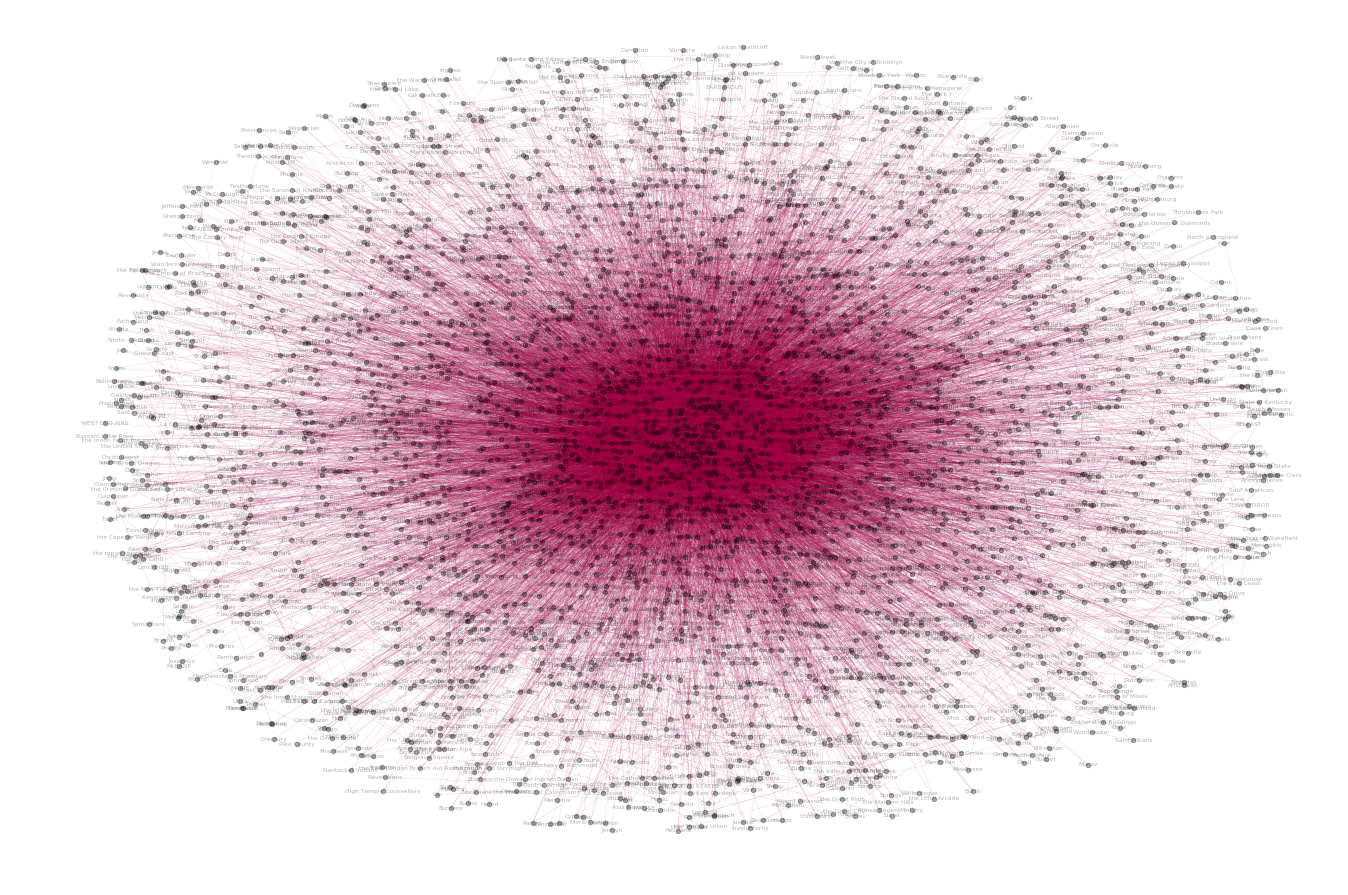

In [55]:
# Visualize the full graph
fig_dir = os.path.join('..', 'data', 'images')

edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
pos = nx.spring_layout(G, k=0.3, iterations=40)
plt.figure(figsize=(18,18))
nx.draw(
    G, pos, node_color="black", node_size=20, edgelist=edges,
    edge_color=weights, width=0.25, edge_cmap=plt.cm.Spectral,
    with_labels=True, font_size=8, alpha=0.3)
plt.savefig(os.path.join(fig_dir, "ps09_location_entity_graph.png"), transparent=True)
plt.show()

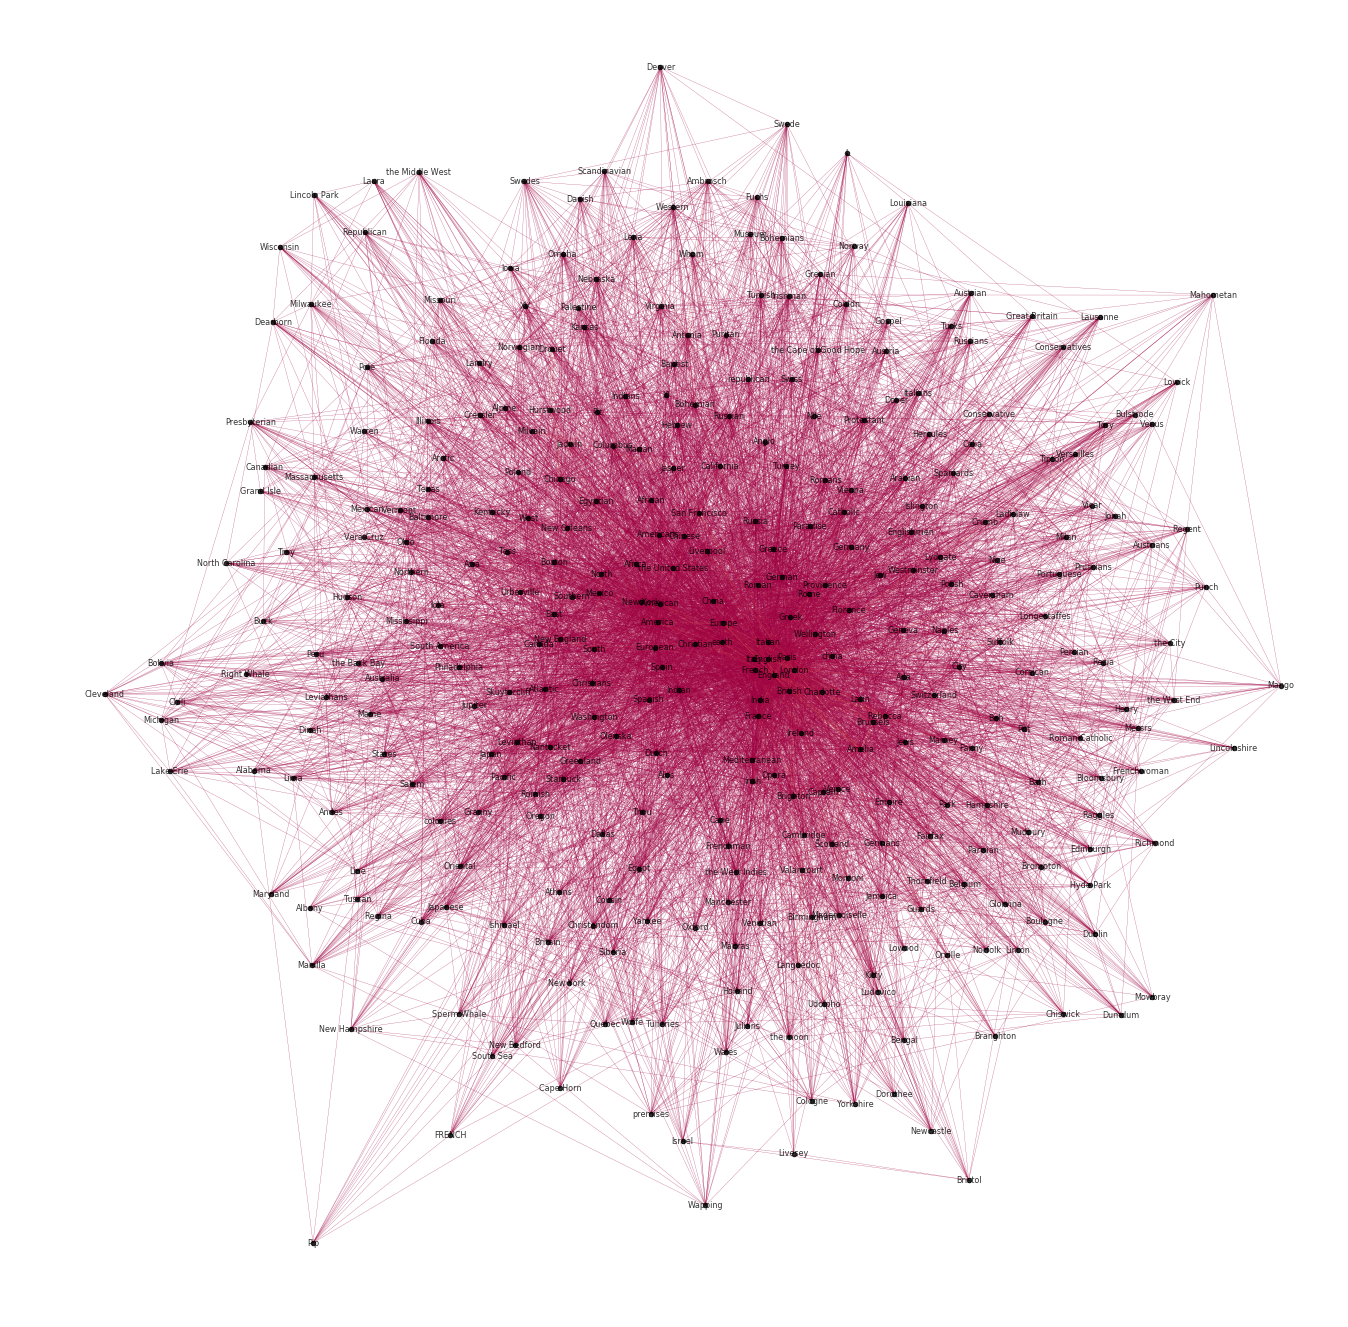

In [74]:
# Filter nodes by degree
selected_nodes = [n for n,v in G.nodes(data=True) if v['centrality'] > 0.01]  
H = G.subgraph(selected_nodes)
selected_edges, selected_weights = zip(*nx.get_edge_attributes(H, "weight").items())

pos = nx.spring_layout(H, k=0.3, iterations=40)
plt.figure(figsize=(18,18))
nx.draw(
    H, pos, node_color="black", node_size=20, 
    edgelist=selected_edges,
    edge_color=selected_weights,
    width=0.25, edge_cmap=plt.cm.Spectral,
    with_labels=True, font_size=8, alpha=0.8)
plt.savefig(os.path.join(fig_dir, "ps09_location_entity_graph_filtered.png"), transparent=True)
plt.show()

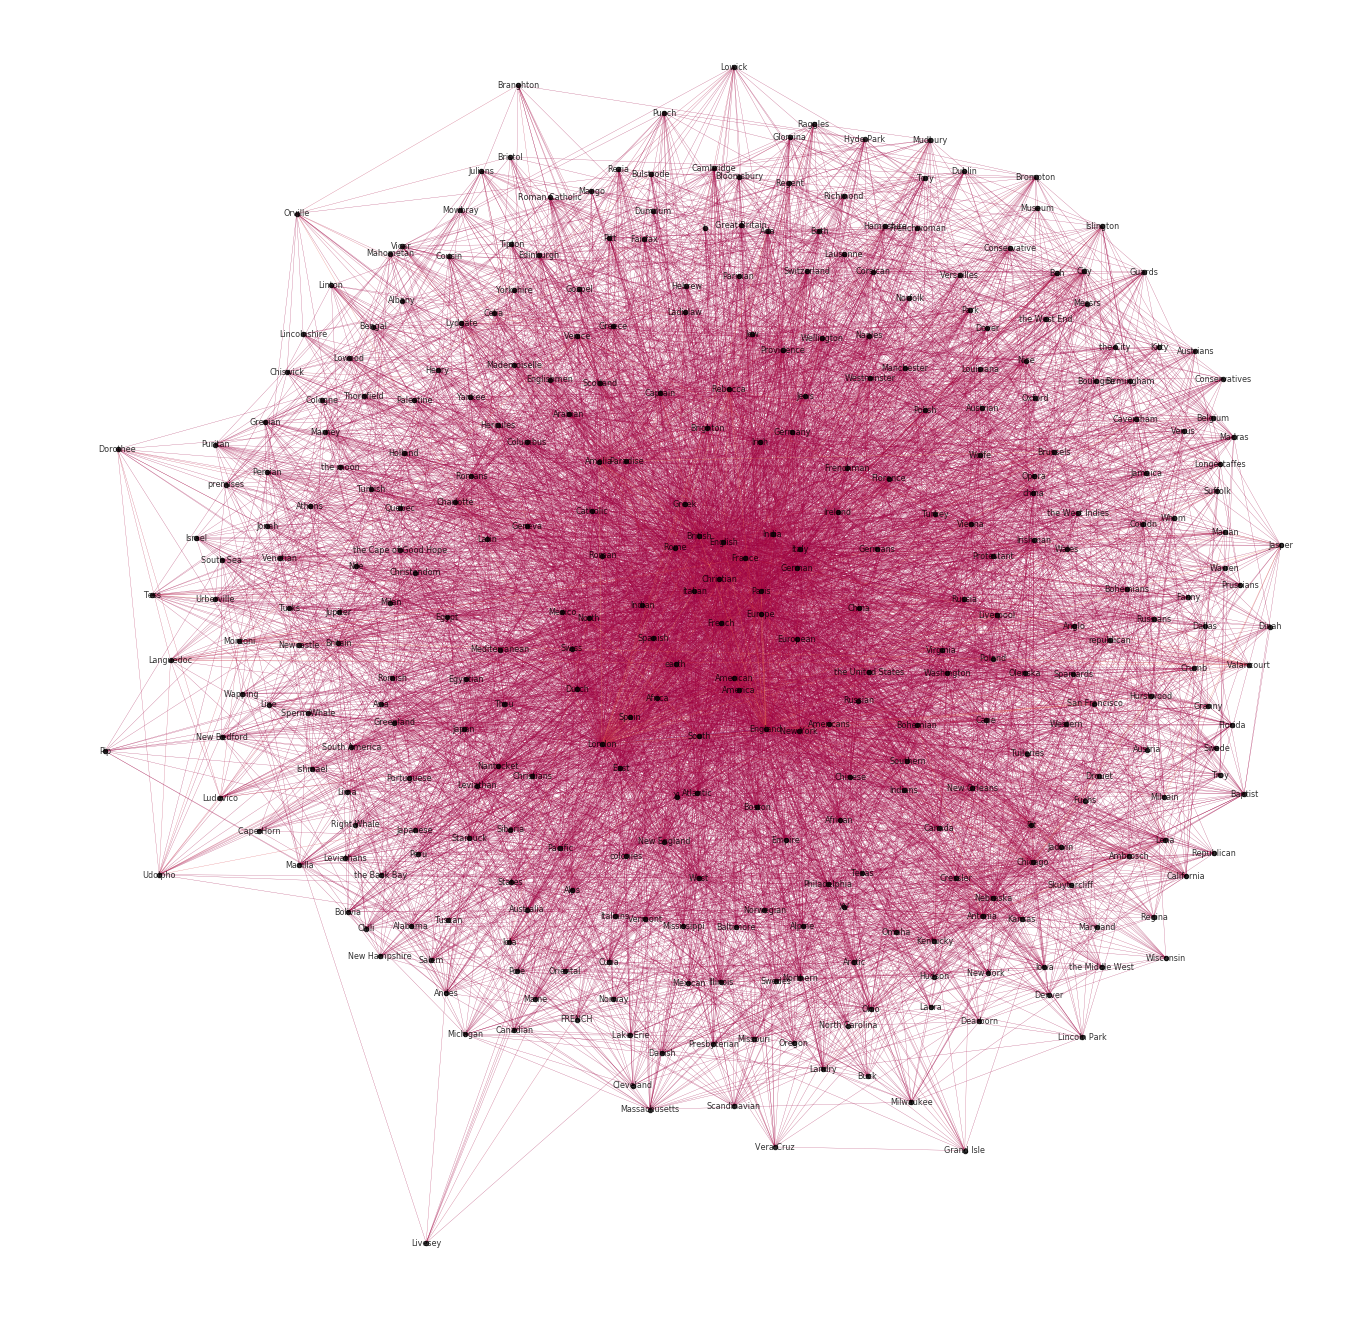

CPU times: user 28.4 s, sys: 461 ms, total: 28.9 s
Wall time: 26.2 s


In [76]:
%%time
plt.figure(figsize=(18,18))
nx.draw_kamada_kawai(
    H, node_color="black", node_size=20, edgelist=selected_edges,
    edge_color=selected_weights, width=0.25, edge_cmap=plt.cm.Spectral,
    with_labels=True, font_size=8, alpha=0.8)
plt.savefig(os.path.join(fig_dir, "ps09_location_entity_graph_alt.png"), transparent=True)
plt.show()